In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Wprowadzenie stałych

In [2]:
m = 2
d = 0.4
I = 0.32
b = 0.15
g = 9.81

t_start = 0
t_end = 10

theta_0 = 0.1

## 1. Zamiana równania 2 rzędu na układ 1 rzędu

In [3]:
def calc_x(t_arg, x_arg):
    x_1, x_2 = x_arg
    dx_1 = x_2
    dx_2 = -(b/I)*x_2 - (m*g*d/I)*np.sin(x_1)
    return np.array([dx_1, dx_2])

vec_x0 = [theta_0, 0]


# 2. Rozwiązać układ (Runge-Kutta 2 i 4 rzędu)

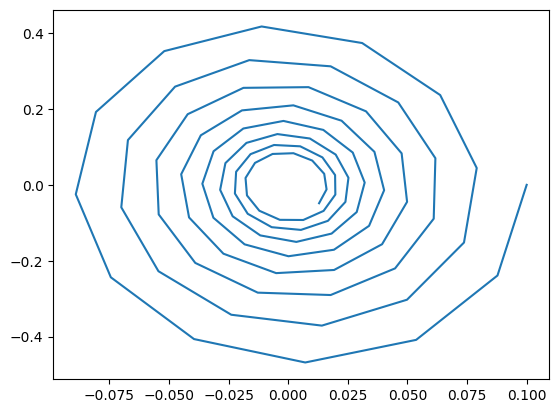

In [5]:
def impl_RK_2(func, time, x0, h):
    n = int(np.ceil((time[1]-time[0])/h))
    t = np.linspace(time[0], time[1], n)

    x = [x0]
    for i in range(1, n):
        xprev = x[i-1]
        tprev = t[i-1]
        x.append(xprev + h*(func(tprev, xprev) + func(tprev+h, xprev+h*func(tprev, xprev)))/2)

    return x


def impl_RK_4():
    pass

result = np.array(impl_RK_2(calc_x, (t_start, t_end), vec_x0, 0.1))

plt.figure()
plt.plot(result[:,0], result[:,1])